<a href="https://colab.research.google.com/github/halizz821/ShipDetection/blob/main/LandCoverClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title ###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License.

# 🎬 Before you begin

We first need to install all the requirements.

In [1]:
!pip install --quiet --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.2 MB/s eta 0:00:00


In [2]:

!pip install apache-beam

# Restart the runtime by ending the process.
exit()

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 91.6 MB/s eta 0:00:00
  Created wheel for crcmod: filename=crcmod-1.7-cp310-cp310-linux_x86_64.whl size=31408 sha256=16b70356b8eb9c73fe2c97d15e81309b4e6ea4f6f97f098704e9002d25d3e291
  Stored in directory: /root/.cache/pip/wheels/85/4c/07/72215c529bd59d67e3dac29711d7aba1b692f543c808ba9e86
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78542 sha256=59baa6cfb54aedaa31e5

> **🛑 Restart the runtime 🛑**

Colab already comes with many dependencies pre-loaded.
In order to ensure everything runs as expected, we **_must_ restart the runtime**. This allows Colab to load the latest versions of the libraries.

!["Runtime" > "Restart runtime"](images/restart-runtime.png)

# ☁️ My Google Cloud resources

Make sure you have followed these steps to configure your Google Cloud project:

1. Enable the APIs: _Earth Engine_

  <button>

  [Click here to enable the APIs](https://console.cloud.google.com/flows/enableapi?apiid=earthengine.googleapis.com)
  </button>

1. Register your
  [Compute Engine default service account](https://console.cloud.google.com/iam-admin/iam)
  on Earth Engine.

  <button>

  [Click here to register your service account on Earth Engine](https://signup.earthengine.google.com/#!/service_accounts)
  </button>

Once you have everything ready, you can go ahead and fill in your Google Cloud resources in the following code cell.
Make sure you run it!

In [1]:
from __future__ import annotations

import os
from google.colab import auth

auth.authenticate_user()

# Please fill in these values.
project = "named-foundry-446220-j0"  # @param {type:"string"}

# Quick input validations.
assert project, "⚠️ Please provide a Google Cloud project ID"

# Set GOOGLE_CLOUD_PROJECT for google.auth.default().
os.environ["GOOGLE_CLOUD_PROJECT"] = project

# Set the gcloud project for other gcloud commands.
!gcloud config set project {project}

Updated property [core/project].


In [2]:
# Now let's get the code from GitHub and navigate to the sample.
!git clone https://github.com/GoogleCloudPlatform/python-docs-samples.git
%cd python-docs-samples/people-and-planet-ai/land-cover-classification

Cloning into 'python-docs-samples'...
remote: Enumerating objects: 119405, done.
remote: Counting objects: 100% (7092/7092), done.
remote: Compressing objects: 100% (1340/1340), done.
remote: Total 119405 (delta 6530), reused 5753 (delta 5752), pack-reused 112313 (from 2)
Receiving objects: 100% (119405/119405), 243.07 MiB | 24.61 MiB/s, done.
Resolving deltas: 100% (72096/72096), done.
Updating files: 100% (5500/5500), done.
/content/python-docs-samples/people-and-planet-ai/land-cover-classification


Next, we have to authenticate Earth Engine and initialize it.
Since we've already authenticated to this [Colab](https://www.youtube.com/watch?v=rNgswRZ2C1Y) and saved them as the [Google default credentials](https://google-auth.readthedocs.io/en/master/reference/google.auth.html#google.auth.default),
we can reuse those credentials for Earth Engine.

> 💡 Since we're making **large amounts of automated requests to Earth Engine**, we want to use the
[high-volume endpoint](https://developers.google.com/earth-engine/cloud/highvolume).

In [3]:
import ee
import google.auth

credentials, _ = google.auth.default()
ee.Initialize(
    credentials.with_quota_project(None),
    project=project,
    opt_url="https://earthengine-highvolume.googleapis.com",  #The high-volume endpointis designed to manage a larger number of requests efficiently.
)

# 📚 Understand the data

Before we begin, let's start by looking at what we want to achieve and the datasets we chose.

A machine learning **model** is like a **function**, you give it some **inputs** and it returns you some **predictions**.
But instead of having to write a lot of specialized code manually, you give it a bunch of **training examples** and it learns from them.
To know what it should learn, you have to give it the _correct output_ (also known as a **label**) for each _input_ during training.
A _training example_ is a **pair of `(inputs, labels)`**.

Let's train a simple model to do 🗺 **land cover classifications**, similar to [Dynamic World](https://dynamicworld.app).
That means classifying each pixel in a map to show if it's water, grass, trees, bare ground, built-up, etc.
Land cover is used in climate, energy, water, agriculture, conservation, and many other sectors.
Many other models can be framed in a very similar way.

## 🌍 Earth Engine basics

[Earth Engine](https://earthengine.google.com) combines petabytes of geospatial data, and a collection of functions to process and analyze it.
We'll use the Earth Engine Python client library, but you can check the [API Reference](https://developers.google.com/earth-engine/apidocs) page to see other ways of using Earth Engine.

Here are some of the basic concepts to know of Earth Engine.

* **Band**: A band is a matrix _(like a 2D table)_ of pixel values. Each pixel in a band has a single numeric value (bytes, integers, floats, etc).
* **[Image](https://developers.google.com/earth-engine/guides/image_overview)**: Earth Engine images are made up of one or more _bands_, each one with their own name.
* **[ImageCollection](https://developers.google.com/earth-engine/guides/ic_creating)**: A collection of zero or more images, similar to a _list of images_.
* **[Geometry](https://developers.google.com/earth-engine/guides/geometries)**: Usually a point coordinate, a polygon, or multi-polygon.
* **[Feature](https://developers.google.com/earth-engine/guides/features)**: Earth Engine features contain a value and a Geometry.
* **[FeatureCollection](https://developers.google.com/earth-engine/guides/feature_collections)**: A collection of zero or more features, similar to a _list of features_.
* **[Scale](https://developers.google.com/earth-engine/guides/scale)**: The pixel resolution of an image, measured in _meters_.

## 🛰 **Inputs**: Sentinel 2 images

The **inputs** of the model are the data we want to give it every time we want a _prediction_ from it.

To get good results from our model, we must provide it with good data.
As a rule of thumb, if a human can solve a problem given some input data, a machine learning model will most likely be able to solve the problem as well.

After looking at some of the options in the
[Earth Engine data catalog](https://developers.google.com/earth-engine/datasets), we decided to use the
[Sentinel-2 MultiSpectral](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_HARMONIZED) satellite images.
Sentinel 2 pictures at a **10 meter resolution** roughly **every five days** for the same region.
However, for simplicity, we'll be using 1-year composites instead of analyzing each individual image.

The Sentinel-2 satellites have multiple specialized sensors, each one capturing different ranges from the 🌈 **electromagnetic spectrum**.
They can capture much more information than professional photography cameras.
Typically, images consist of three values, or channels, (Red, Green, Blue) for every pixel.
Sentinel-2 has 13 different values, or
_bands_, for every pixel!
For us humans, it's hard to visualize such a broad spectrum, but machine learning can learn the patterns behind them given enough training examples.

One common challenge when dealing with satellite imagery is that the Earth has ☁️ _clouds_, lots of them, especially in tropical areas.
Clouds are great for rain and keeping our weather balanced, but when it comes to processing pictures taken from outer space, they're tricky to deal with.

Fortunately, many satellite images have metadata associated with their images to locate where there (probably) are clouds.
For example, Sentinel-2 has a `CLOUDY_PIXEL_PERCENTAGE` property which tells us how much of an image is covered in clouds.
Additionally, there's a `QA60` (Quality Assurance) band, that's a
[_bitmask_](https://en.wikipedia.org/wiki/Mask_(computing))
which includes a couple bits to know if a pixel contains clouds or not.

We can mask (hide) pixels containing clouds in a Sentinel 2 image with this function.

In [4]:
import ee


def mask_sentinel2_clouds(image: ee.Image) -> ee.Image:
    CLOUD_BIT = 10
    CIRRUS_CLOUD_BIT = 11
    bit_mask = (1 << CLOUD_BIT) | (1 << CIRRUS_CLOUD_BIT)  # 1 << CLOUD_BIT is shift 1 (in binary format) 10 element to the left (it basiclly show 2 ^ 10)
    mask = image.select("QA60").bitwiseAnd(bit_mask).eq(0)
    return image.updateMask(mask)  # Apply the Mask (you willget non-cloudy pixel only)

To get our Sentinel 2 yearly composite, first we take the Sentinel 2 ImageCollection.
Then we filter the images to only keep the ones from the year of interest.
Next we mask the cloudy pixels, select the bands we'll use, and take the median of all the non-cloudy pixels.

When we get the pixel values from Earth Engine, there might be areas that had clouds all year long like some areas in the tropics.
Earth Engine still gives us the data, but any masked pixels will have a value of [`NaN` (Not a Number)](https://en.wikipedia.org/wiki/NaN).
Our model will do strange things if we feed it NaNs or infinities, so let's get rid of them.

There are many ways of dealing with _missing values_, and it all depends on what you're trying to achieve.
A common way is filling missing values with _zero_.
Here, we have numeric data from light sensors, like a camera.
It's unrealistic having zeroes like completely black objects absorbing everything.
By analyzing the common data range and visualizing the data with different values for missing data, filling them with `1000` seemed like a good value.
We used [`ee.Image.unmask`](https://developers.google.com/earth-engine/apidocs/ee-image-unmask) to remove the mask from the image, and fill in the missing values with `1000`.

Finally, Sentinel 2 saves the data as `double` (`float64`).
But since machine learning is probabilistic, we don't need that much precision.
Also, if we're trying to run our model in hardware accelerators, we usually have to convert our data to `float32`s anyway.
So at the end, we convert the data to `float32` as an optimization to make smaller data transfers and reduce the size of the training dataset.

In [5]:
import ee


def get_input_image(year: int, default_value: float = 1000.0) -> ee.Image:
    return (
        ee.ImageCollection("COPERNICUS/S2_HARMONIZED")  # Sentinel-2 images
        .filterDate(f"{year}-1-1", f"{year}-12-31")  # filter by year
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))  # filter cloudy images
        .map(mask_sentinel2_clouds)  # mask/hide cloudy pixels
        .select("B.*")  # select all bands starting with B
        .median()  # median of all non-cloudy pixels
        .unmask(default_value)  # default value for masked pixels. It fill the values of nan for pixel that was cloudy and masked in all of the imaages
        .float()  # convert to float32
    )

> 💡 [`ee.Image.select`](https://developers.google.com/earth-engine/apidocs/ee-image-select) supports [regular expressions](https://en.wikipedia.org/wiki/Regular_expression).
> For example in `B.*`, it first matches the `B`. The `.` is a _wildcard_ to match any character, and the `*` means zero or more of the `.`, so it matches `B` followed by zero or more of any character.

For visualization, bands `(B4, B3, B2)` correspond to `(Red, Green, Blue)` respectively.
We can use [Folium](https://python-visualization.github.io/folium) to visualize it as an interactive map.
Here's an example image of a
[copper mine in Cananea, Sonora, Mexico](https://earthobservatory.nasa.gov/images/8680/cananea-copper-mine-sonora-mexico).

In [6]:
import folium

image = get_input_image(2020)
vis_params = {
    "min": 0,
    "max": 3000,
    "bands": ["B4", "B3", "B2"],
}
folium.Map(
    location=(30.95, -110.29),
    zoom_start=13,
    tiles=image.getMapId(vis_params)["tile_fetcher"].url_format,  # This overlays the processed Sentinel-2 image onto the map as a tile layer.
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>', # just for copy right
)

> ![Sentinel 2 map in Earth Engine](images/sentinel2-map.png)

## 🗺 **Labels**: Land cover map

The **labels** are the _expected outputs_ of our model.
We'll be pairing the _labels_ with their respective _inputs_ to create the _training examples_.

Machine learning models learn by example, so we need to show them how an actual land cover map looks like for a given patch of Sentinel-2 pixels.

Earth Engine has the
[European Space Agency WorldCover map](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v100),
which is a 10 meter resolution land cover map of the entire world for the year 2020.
It was actually derived from the Sentinel-2 images, that's why they both have a 10 meter resolution.

We only have data from 2020, so using the Sentinel-2 median for the entire year makes things easier.
But our model, will be able to make predictions on data from years and regions it hasn't seen before during training.

Just like the input data, we also want to fill missing values.
The land cover map only has data for the land, not for the oceans, so in this case we want to fill the missing values with `water` which is 0 in the way we encoded our classifications.

We also only have 9 classifications.
A byte (unsigned 8-bit integer) can fit up to 2^8 (256) different values, way more than what we need to store just 9 values.
So we convert the classifcations into bytes to optimize data transfers as well.

Here's how the same copper mine looks like in the land cover map.

In [7]:
from visualize import CLASSIFICATIONS

In [8]:
import ee
import folium

from visualize import CLASSIFICATIONS


def get_label_image() -> ee.Image:
    # Remap the ESA classifications into the Dynamic World classifications
    fromValues = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100]
    toValues = [1, 5, 2, 4, 6, 7, 8, 0, 3, 3, 7]
    return (
        ee.Image("ESA/WorldCover/v100/2020")
        .select("Map")
        .remap(fromValues, toValues)
        .rename("landcover")
        .unmask(0)  # fill missing values with 0 (water)
        .byte()  # 9 classifications fit into an unsinged 8-bit integer.   An 8-bit unsigned integer can store integer values between 0 and 255. it reeduce size.
    )


image = get_label_image()

vis_params = {
    "bands": ["landcover"],
    "max": len(CLASSIFICATIONS) - 1,
    "palette": list(CLASSIFICATIONS.values()),
}
folium.Map(
    location=(30.95, -110.29),
    zoom_start=13,
    tiles=image.getMapId(vis_params)["tile_fetcher"].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
)

> ![European Space Agency WorldMap](images/esa-worldmap.png)

We can see there's a clear distinction between the "natural world" and the "human-made world".
The mining complex itself looks like _bare ground_, which makes sense since all the topsoil has been removed to scratch the inner minerals.
The surrounding areas look like mostly _shrub_, _scrub_, _grasses_, and some _trees_.
We can also see the _built-up_ roads from the city of Cananea at the northern area.

There are multiple pools of
[leachate](https://en.wikipedia.org/wiki/Leachate)
used for the ore extraction, classified as "water" by the land cover map.

In [ ]:
from visualize import show_legend

show_legend()

    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


# 🗄 Create the dataset

The **dataset** is just a **collection of `(inputs, labels)` pairs**.
Something to consider, is that we want a _balanced_ dataset that has an even distribution between all the different cases we want our model to learn from.
Having too many samples of one case and too few of another might lead to _bias_ in our model.

## 📌 Sample points

> _"[Earth] is big. Really big. You just won't believe how vastly hugely mind-bogglingly big it is."_
>
> _-- 🛸 Hitchhiker's Guide to the Galaxy -- Douglas Adams_

The Earth might not be as big as space, but it still contains a _huge_ amount of data.
Sentinel-2 takes float64 numbers for each pixel with a 10 resolution, for 13 bands, for roughly every five days.
Training on the entire world would not only use a **huge amount of resources,** it would take a _very long time_ to finish.

A quick and statistically sound alternative, would be to randomly pick points and use those as our training data.
That should be an evenly distributed set of points.
But there's another problem, around 71% of the Earth's surface is water.
That means that if our model guesses that _everything_ is water, it would have 71% accuracy!
Not too bad, right? 🤔

Fortunately, Earth Engine has a function called [`ee.Image.stratifiedSample`](https://developers.google.com/earth-engine/apidocs/ee-image-stratifiedsample) that picks the same number of points for every classification in an `ee.Image`.
We only have 9 classifications, so if we tell it to pick 100 points per classification, we would end up with a dataset of 900 examples.

In [10]:
from typing import Iterable

import ee


def sample_points(
    region: ee.Geometry, image: ee.Image, points_per_class: int, scale: int
) -> Iterable[tuple[float, float]]:
    points = image.stratifiedSample(
        points_per_class,
        region=region,
        scale=scale,
        geometries=True,
    )
    for point in points.toList(points.size()).getInfo():
        yield point["geometry"]["coordinates"]


# Oversimplified North America region.
polygon = [[[-145.7, 63.2], [-118.1, 22.3], [-78.2, 5.6], [-52.9, 47.6]]]
region = ee.Geometry.Polygon(polygon)
labels_image = get_label_image()
for point in sample_points(region, labels_image, points_per_class=2, scale=1000):
    print(point)

[-112.26253600096747, 40.72366118754205]
[-88.83447339113036, 48.17967804573408]
[-85.60053836830008, 35.02834228622428]
[-72.4042868445843, 45.565580568946274]
[-102.81225921203011, 65.46326411219367]
[-117.42784888465474, 61.870002975715586]
[-89.77770443945586, 56.68672378634595]
[-90.16398001162725, 55.07873942777201]
[-94.88013525325474, 40.283486698323486]
[-99.05730132441052, 47.21848069172619]
[-109.63047221849727, 30.159473446296474]
[-113.61000892714677, 28.10233144566277]
[-121.40738559330421, 38.68448549259074]
[-85.65443728534726, 40.543998130718144]
[-113.98730134647695, 38.90008116077942]
[-101.39292106312126, 65.28360105536977]
[-141.42185012348716, 60.63931103647184]
[-141.6823615558818, 60.62134473078945]


> 💡 If you have a _regression_ problem where you want to predict a _number_ instead of a _classification_, you could convert the numbers to integers.
> If the numbers are too large, you could bucketize them by dividing them by a constant before converting them to integers.


## 📑 Get training examples

Now that we have all the point coordinates we want to get, we can fetch their **surrounding patches** from Earth Engine.

We use the
[ee.Image.getDownloadURL](https://developers.google.com/earth-engine/apidocs/ee-image-getdownloadurl)
method to give us a download link to the patch pixels data as a
[NumPy](https://numpy.org/) array.

One thing to note is that since we'll be doing lots of _requests in parallel_, we'll most likely be getting errors with
[status 429: Too Many Requests](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/429)
from Earth Engine.
We can safely retry the request if we get that error.
A simple way to do it is with the
[`google.api_core.retry`](https://googleapis.dev/python/google-api-core/latest/retry.html)
library, but there's a catch.
That library only understands exceptions from the [`google.api_core.exceptions`](https://googleapis.dev/python/google-api-core/latest/exceptions.html) library.
To quickly fix this, if we get a status 429 error, we can simply raise the appropriate `google.api_core` exception.

In [11]:
import io
import numpy as np
import requests
from google.api_core import exceptions, retry


@retry.Retry(deadline=10 * 60)  # seconds.    enabling automatic retries for up to 10 minutes (600 seconds) if transient errors occur.
def get_patch(
    image: ee.Image, lonlat: tuple[float, float], patch_size: int, scale: int
) -> np.ndarray:
    point = ee.Geometry.Point(lonlat)
    url = image.getDownloadURL( #enerates a URL to download the specified patch from the ee.Image
        {
            "region": point.buffer(scale * patch_size / 2, 1).bounds(1), # Creates a circular buffer around the point with a radius equal to half the patch size (scaled by resolution).
                                                                         # .bounds(1): Converts the buffer into a rectangular bounding box.
            "dimensions": [patch_size, patch_size],
            "format": "NPY", # Specifies the output format as .npy (NumPy array format).
        }
    )

    # If we get "429: Too Many Requests" errors, it's safe to retry the request.
    # The Retry library only works with `google.api_core` exceptions.
    response = requests.get(url) # Sends an HTTP GET request to the URL generated above to fetch the patch data.
    if response.status_code == 429:
        raise exceptions.TooManyRequests(response.text) #If the error occurs, raises a TooManyRequests exception with the error message, allowing the retry decorator to handle the retry logic.

    # Still raise any other exceptions to make sure we got valid data.
    response.raise_for_status() # Checks if the HTTP request was successful (status code 200).
    return np.load(io.BytesIO(response.content), allow_pickle=True)
    # response.content: The raw binary content of the .npy file downloaded from the URL.
    # io.BytesIO(...): Wraps the binary content in an in-memory stream, allowing it to be loaded as if it were a file.


> 💡 If you need, you can request an increase of quota of the number of concurrent requests you can make.
> For more information, see the
[High-volume endpoint](https://developers.google.com/earth-engine/cloud/highvolume) page.

Note that Earth Engine returns the data as a
[structured array](https://numpy.org/doc/stable/user/basics.rec.html).
You can think of structured arrays similar to a multidimensional
[Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html), or spreadsheet.
They're like a "table" containing multidimensional data.
We want dense tensors instead of structured arrays, so we use [`structured_to_unstructured`](https://numpy.org/doc/stable/user/basics.rec.html#numpy.lib.recfunctions.structured_to_unstructured) and the bands automatically go to an extra dimension at the end.

Now, let's create some helper functions to get the inputs and labels patches of pixels.
We'll use this function both for getting inputs for the training examples, and for predictions later on.

In [12]:
from numpy.lib.recfunctions import structured_to_unstructured


def get_input_patch(
    year: int, lonlat: tuple[float, float], patch_size: int
) -> np.ndarray:
    image = get_input_image(year)
    patch = get_patch(image, lonlat, patch_size, scale=10)
    return structured_to_unstructured(patch)  # turn Structured Arrays to simple matrices (unstructured array)


def get_label_patch(lonlat: tuple[float, float], patch_size: int) -> np.ndarray:
    image = get_label_image()
    patch = get_patch(image, lonlat, patch_size, scale=10)
    return structured_to_unstructured(patch)

> 💡 It's very important to use input data for predictions in _exactly_ the same format than the one used for training.
> Sharing the same function for both makes sure they're the same.

It would also be useful to create a function to get a whole training example.
Since we only have labels for year 2020, we don't need to ask for the year for the inputs.

In [13]:
def get_training_example(
    lonlat: tuple[float, float], patch_size: int = 128
) -> tuple[np.ndarray, np.ndarray]:
    return (
        get_input_patch(2020, lonlat, patch_size),
        get_label_patch(lonlat, patch_size),
    )


point = (-110.312, 30.972)  # (lon, lat)
(inputs, labels) = get_training_example(point)
print(f"inputs : {inputs.dtype} {inputs.shape}")
print(f"labels : {labels.dtype} {labels.shape}")

inputs : float32 (128, 128, 13)
labels : uint8 (128, 128, 1)


We asked for a patch of **128 pixels** and our inputs have **13 bands**, so we got a patch with a shape of `(128, 128, 13)`.
For labels, we have a single value with the classification as a `uint8`.

Let's see how the data looks!

In [12]:
from visualize import show_example

show_example(inputs, labels)

## ✍🏽 Serialize to TFRecords

Finally, since we'll be training a
[TensorFlow](https://tensorflow.org/)
model, it would be good to write our datasets as
[TFRecords](https://www.tensorflow.org/tutorials/load_data/tfrecord).
To use other frameworks like [PyTorch](https://pytorch.org), [scikit-learn](https://scikit-learn.org/stable), or [XGBoost](https://xgboost.readthedocs.io/en/stable/) we could use any other file format that's easieast for us, like [compressed NumPy files](https://numpy.org/doc/stable/reference/generated/numpy.savez_compressed.html).

For TFRecords, we have to convert our data into a
[`tf.train.Example`](https://www.tensorflow.org/api_docs/python/tf/train/Example).
It consists of a _dictionary of tf.Features_ (different to ee.Features), where each tf.Feature can be a list of bytes, floats, or int64s.
Note that it can _only_ save flat lists, so it won't save the shapes.
As a workaround, we use [`tf.io.serialize_tensor`](https://www.tensorflow.org/api_docs/python/tf/io/serialize_tensor) to first serialize our dense tensors into bytes including their shape information.
As an added benefit, serialized tensors are a space efficient binary format.

Then we save one tf.Feature for the inputs, and another one for the outputs.
Finally, we serialize the entire tf.Example into bytes.

In [14]:
import tensorflow as tf


def serialize(inputs: np.ndarray, labels: np.ndarray) -> bytes:
    features = {
        name: tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(data).numpy()])
        )
        for name, data in {"inputs": inputs, "labels": labels}.items()
    }
    example = tf.train.Example(features=tf.train.Features(feature=features))
    return example.SerializeToString()


serialized = serialize(inputs, labels)
print(f"serialized: {len(serialized)} bytes")

serialized: 868448 bytes


1) `tf.train.Feature`:
*   Converts the data into a `tf.train.Feature` object.
*   `tf.train.BytesList:`
      *   Stores binary data (in this case, the serialized tensor).
      *  ` tf.io.serialize_tensor(data)`
        *   Serializes the data (a NumPy array) into a binary tensor, preserving both its shape and content.
        * `.numpy()`
           * Converts the serialized tensor into a NumPy array, which is compatible with BytesList.

Resulting Features:

A dictionary of `tf.train.Feature` objects where keys are "inputs" and "labels", and values are the serialized data.


There is a trick here in the loop below:
It is hard to explain but you can use chat-gpt to understand it

* `for name, data in {"inputs": inputs, "labels": labels}.items()`


----------------------------------------------------------------

2)  `example = tf.train.Example(features=tf.train.Features(feature=features))`
* Represents a single example (or record) in the TFRecord file.
* Takes the features dictionary and wraps it in a tf.train.Features object.


## 🗃 Create the dataset

We have all the pieces now, so lets put all together into an
[Apache Beam](https://beam.apache.org) pipeline.
Apache Beam allows us to create parallel processing pipelines.

The pipeline uses
[`FlatMap`](https://beam.apache.org/documentation/transforms/python/elementwise/flatmap/) to sample balanced points on our region of interest.
Then it
[`Map`](https://beam.apache.org/documentation/transforms/python/elementwise/map/)s the `get_training_example` function, which gets us a pair of `(inputs, labels)`.
Finally, we serialize them to TFRecords and write them to compressed TFRecord files with [`WriteToTFRecord`](https://beam.apache.org/releases/pydoc/current/apache_beam.io.tfrecordio.html#apache_beam.io.tfrecordio.WriteToTFRecord).

Running this locally works great for testing things out with small datasets, but for larger datasets we should be using a [distributed runner](https://beam.apache.org/documentation/runners/capability-matrix/) like
[Dataflow](https://cloud.google.com/dataflow).

In [15]:
import apache_beam

In [40]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions

polygon = [[[-145.7, 63.2], [-118.1, 22.3], [-78.2, 5.6], [-52.9, 47.6]]]
region = ee.Geometry.Polygon(polygon)
labels_image = get_label_image()

with beam.Pipeline() as pipeline:
    (
        pipeline
        | "🗺 Create region" >> beam.Create([region])
        | "📌 Sample points"
        >> beam.FlatMap(sample_points, labels_image, points_per_class=10, scale=1000)
        | "📑 Get examples" >> beam.Map(get_training_example)
        | "✍🏽 Serialize" >> beam.MapTuple(serialize)
        | "📚 Write TFRecords"
        >> beam.io.WriteToTFRecord("data/part", file_name_suffix=".tfrecord.gz")
    )

> 💡 For more information on how to use Apache Beam, refer to the
> [Tour of Beam](https://beam.apache.org/get-started/tour-of-beam/)

In [17]:
!ls -lh data/*.tfrecord.gz

-rw-r--r-- 1 root root 23M Jan 11 14:55 data/part-00000-of-00001.tfrecord.gz


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.getcwd())


In [18]:
!pwd

/content/python-docs-samples/people-and-planet-ai/land-cover-classification


# 🧠 Train the model

We finally have a dataset of training examples on which to train the model.
The overall process of training the model is _pretty straightforward_, but there's a lot of things to know on how to set it up.

First, some basic definitions:

- 🔮 **Model**: You can think of the model as a function. You give it some inputs and it returns you some outputs. But rather than writing the function yourself, it learns from examples.
- 🧮 **Tensor**: Tensors are 🌌 multi-dimensional numbers. _Scalars_ have 0 dimensions. _Vectors_ have 1 dimension. _Matrices_ have 2 dimensions. _Tensors_ can have any number of dimensions. Machine learning models take tensors as inputs and return tensors.
- 🏗️ **Shape**: This says how many dimensions and how they look. For example, a 3x4 matrix has shape `(3, 4)`, and an 800x600 RGB image has a shape `(800, 600, 3)`, because it has three numbers (red, green, blue) for every pixel.

## 📖 Read the dataset

Let's start by looking at the data files that we just created.
We can use
[`tf.data.TFRecordDataset`](https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset)
to read the TFRecord files, but we'll get `bytes` for each element.

In [41]:
import tensorflow as tf

filenames = tf.data.Dataset.list_files(f"data/*.tfrecord.gz")
dataset = tf.data.TFRecordDataset(filenames, compression_type="GZIP")

# We get bytes directly from the TFRecords.
for x in dataset.take(1):
    a = x.numpy()
    print(f"{type(x.numpy()).__name__} {len(x.numpy())}")

bytes 868448


The next step is to define a function to parse and read the serialized tf.Examples and give us back the original `(inputs, labels)` pair.
First we use [`tf.io.parse_single_example`](https://www.tensorflow.org/api_docs/python/tf/io/parse_single_example) to parse the tf.Example using a tf.Features dictionary.
Both the _inputs_ and _labels_ are a simple `tf.string` since they're serialized, so we use [`tf.io.parse_tensor`](https://www.tensorflow.org/api_docs/python/tf/io/parse_tensor) to parse the individual _inputs_ and _labels_ tensors, each one with their respective data types.

Since we're parsing serialized tensors, TensorFlow isn't able to infer the shapes of the dataset, so we have to set them explicitly.
The patch size is variable sized, so we use `None`, but the number of inputs and outputs are constants we must provide.

Finally, the model expects classifications as [one-hot](https://en.wikipedia.org/wiki/One-hot) encoded vectors, instead of integers.
We use [`tf.one_hot`](https://www.tensorflow.org/api_docs/python/tf/one_hot) to convert them.

In [42]:
NUM_INPUTS = 13
NUM_CLASSES = 9


def read_example(serialized: bytes) -> tuple[tf.Tensor, tf.Tensor]:
    # serialized: A single serialized TFRecord example (as a binary string).
    features_dict = { # A dictionary defining the structure of the TFRecord example.
        "inputs": tf.io.FixedLenFeature([], tf.string), #[]: The feature is scalar (a single string).
        "labels": tf.io.FixedLenFeature([], tf.string), # tf.string: The feature contains serialized tensor data as a string.
    }
    # Parses the serialized TFRecord data into a dictionary (example) containing deserialized feature values.
    example = tf.io.parse_single_example(serialized, features_dict)

    inputs = tf.io.parse_tensor(example["inputs"], tf.float32)#  Deserialize Tensors: Converts the serialized string back into a TensorFlow tensor.
    labels = tf.io.parse_tensor(example["labels"], tf.uint8)

    # TensorFlow can't infer the shapes, so we set them explicitly.
    inputs.set_shape([None, None, NUM_INPUTS])
    labels.set_shape([None, None, 1])

    # Classifications are measured against one-hot encoded vectors.
    one_hot_labels = tf.one_hot(labels[:, :, 0], NUM_CLASSES)
    return (inputs, one_hot_labels)


filenames = tf.data.Dataset.list_files(f"data/*.tfrecord.gz")
dataset = tf.data.TFRecordDataset(filenames, compression_type="GZIP").map(read_example)

for inputs, labels in dataset.take(1):
    print(f"inputs : {inputs.dtype.name} {inputs.shape}")
    print(f"labels : {labels.dtype.name} {labels.shape}")

inputs : float32 (128, 128, 13)
labels : float32 (128, 128, 9)


The shapes are looking great!
We got back our original data from the TFRecords! 🎉

## 🍴 Split the dataset

But during training, our model might be memorizing the dataset and give us weird results when we try to get predictions on data it has never seen before.
For this reason, it's common to _split_ our dataset into a _training dataset_ and a _testing (validation) dataset_.

The _training dataset_ is what the model uses to learn and adjust itself.
It goes through this dataset multiple times, each time it goes through the entire dataset is called an _epoch_.

The _testing (or validation) dataset_ is used like an _exam_.
It's important that the testing dataset does **not** include examples found in the training dataset, or the validation will be [biased](https://developers.google.com/machine-learning/crash-course/fairness/types-of-bias).
After going through the training dataset, the model will check itself against the testing dataset, which should include data it has not seen (learned from) before.

You can choose how much data to use for training and for testing, 80% for training and 20% for testing, or 90% for training and 20% for testing are common choices.
Since we're experimenting with a really small dataset, we'll go with 90% to maximize the training data.

Finally, we also _shuffle_ the training dataset, and _batch_ both datasets.
There's no need to shuffle the testing dataset.
Models always expect _batches_ of inputs instead of individual inputs.

In [23]:
# Print # of total samples
num_samples = dataset.reduce(0, lambda x, _: x + 1)
print(f"Total samples in the dataset: {num_samples.numpy()}")

Total samples in the dataset: 90


In [44]:
BATCH_SIZE = 8
TRAIN_TEST_RATIO = 80  # percent for training, the rest for testing

# This function splits the input tf.data.Dataset into training and testing subsets.
def split_dataset(dataset: tf.data.Dataset) -> tuple[tf.data.Dataset, tf.data.Dataset]:
  # Input: A tf.data.Dataset object containing all the data (e.g., images and labels).

    indexed_dataset = dataset.enumerate()  # add an index to each example. Indexed dataset: [(0, "data1"), (1, "data2"), (2, "data3"), ...],  is used to split the data
    train_dataset = (
        indexed_dataset.filter(lambda i, _: i % 100 <= TRAIN_TEST_RATIO) # Loops over each example in the dataset. and filter
        .map(lambda _, data: data)  # remove index
        .shuffle(BATCH_SIZE * 8)  # randomize the examples for the batches
        .batch(BATCH_SIZE)  # batch randomized examples
    )
    test_dataset = (
        indexed_dataset.filter(lambda i, _: i % 100 > TRAIN_TEST_RATIO)
        .map(lambda _, data: data, num_parallel_calls=tf.data.AUTOTUNE)  # remove index
        .batch(BATCH_SIZE)  # batch the parsed examples, no need to shuffle
    )
    return (train_dataset, test_dataset)


(train_dataset, test_dataset) = split_dataset(dataset)
for inputs, labels in train_dataset.take(1):
    print(f"inputs : {inputs.dtype.name} {inputs.shape}")
    print(f"labels : {labels.dtype.name} {labels.shape}")

inputs : float32 (8, 128, 128, 13)
labels : float32 (8, 128, 128, 9)


In [45]:
num_batch_train_samples = train_dataset.reduce(0, lambda x, _: x + 1)
num_batch_test_dataset = test_dataset.reduce(0, lambda x, _: x + 1)

print(f"Total # of batches in training dataset: {num_batch_train_samples.numpy()}")
print(f"Total # of batches in validation dataset: {num_batch_test_dataset.numpy()}")

Total # of batches in training dataset: 11
Total # of batches in validation dataset: 2


> 💡 If you want to learn more on how to optimize your TensorFlow datasets, see the
[Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) guide.

Note that when we batch examples together, we get an extra dimension at the beginning.
So now our input shapes are `(batch_size, patch_size, patch_size, inputs)`.

## 🏛 Model architecture (optional)


_**Input layers**_

Now we know that our model accepts inputs as a **dense tensor** with shape `(patch_size, patch_size, num_input_bands)` and **returns us land cover probabilities** with shape `(patch_size, patch_size, num_classes)`.
We want the `patch_size` to be **variable sized**, so we can pass patches of pixels of **any size** into it.
In TensorFlow Keras, `None` means it's a variable sized dimension, so our inputs would be of shape `(None, None)`.
We create an
[`Input` layer](https://www.tensorflow.org/api_docs/python/tf/keras/Input)
for every input band where we define the input shapes.
An `Input` layer doesn't transform the data in any way.

In [ ]:
tf.keras.Input(shape=(None, None, NUM_INPUTS), name="inputs")

<KerasTensor: shape=(None, None, None, 13) dtype=float32 (created by layer 'inputs')>

We got **shapes** `(None, None, None, 13)` for each input even though we defined them with shape `(None, None, 13)`.
That's expected, Keras always inserts a new dimension for the batch size, so our inputs in reality are of shape `(batch_size, patch_size, patch_size, 13)`.

_**Preprocessing layers**_

The Sentinel-2 sensors also save their data in a range roughly between 0 and 10,000, but that varies depending on each measuring instrument.

_Machine learning doesn't like large numbers_, they tend to make the model less stable and makes it hard for it to learn.
Ideally we want _small numbers_, roughly inbetween -1 and 1. It doesn't have to be too strict, having slightly larger or smaller numbers from time to time won't hurt.
Since we're just dealing with numeric data, we can use a
[`Normalization` layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization)
which analyzes the _training_ dataset and figures out how to scale them, then it automatically scales the values as part of the model!

This means we can pass the model the raw Sentinel-2 data, rather than relying on us humans to scale the data in _exactly_ the same way it was scaled during training.

> ⚠️ **Always** analyze _only_ the training dataset, _never_ the validation dataset.
> Looking into the validation dataset creates
> [bias](https://developers.google.com/machine-learning/crash-course/fairness/types-of-bias)
> on the model.
> It's like letting someone peek into an exam, and then taking that same exam.

In [ ]:
# Adapt the Normalization layer with the training dataset.
normalization = tf.keras.layers.Normalization()
normalization.adapt(train_dataset.map(lambda inputs, _: inputs))

# Here's the mean from the training dataset.
print(f"mean : {normalization.mean.shape}")
print(normalization.mean.numpy())

# Here's the variance from the training dataset.
print(f"variance : {normalization.variance.shape}")
print(normalization.variance.numpy())

mean : (1, 1, 1, 13)
[[[[2251.5737   2077.2922   1964.8369   2007.2002   2173.3584
    2557.068    2748.1978   2689.5618   2906.043    1108.7563
      17.461578 1938.5713   1286.9795  ]]]]
variance : (1, 1, 1, 13)
[[[[5.0709920e+06 5.4361730e+06 4.9283575e+06 5.2986450e+06
    4.7824450e+06 3.9417682e+06 3.4353425e+06 3.0349602e+06
    2.9573782e+06 8.3815275e+05 4.6845528e+01 1.4508015e+06
    7.9182438e+05]]]]


All the values are nice and small, perfect for the next layer in our model.

> 💡 The `Normalization` layer is one of TensorFlow Keras preprocessing layers.
> To learn more about other preprocessing layers and how to use them, see the
> [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide.

_**Output layer**_

Finally, the output layer changes a lot depending on what we're trying to do.
We usually use a simple
[`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
layer for outputs.
What changes is the _activation function_.

- **Regression**: To predict a numeric value, we use a `Dense` layer with a single output and
  [_linear activation_](https://www.tensorflow.org/api_docs/python/tf/keras/activations/linear).
  We want to leave the predicted value as it is.
- **Binary classification**: To classify either one thing or another, we use a `Dense` layer with a single output and
  [_sigmoid activation_](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid).
  We want to scale the output between 0 and 1.
  For example, if we want to predict if it will rain or not, we can interpret the resulting value as the _probability_ of rain.
- **Multi-class classification**: To classify one of more than two possibilities, we use a `Dense` layer with the same outputs as we have classifications, and a
  [_softmax activation_](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax).
  We want to scale each output into values between 0 and 1 such that the sum of all of them is 1, this is called a _probability distribution_.

In our case, we are doing _multi-class classification_ since we have 9 possible land cover classifications.
So we need a `Dense` layer with 9 outputs (units), and a _softmax activation_.

In [ ]:
# Dense output layer for multi-class classification.
tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")

_**Optimizers and loss functions**_



Just like the output layers, this changes depending on what we're trying to do.
Here's a table summarizing what to do on each case.

| Goal                       | Outputs       | Activation  | Loss function                |
| -------------------------- | ------------- | ----------- | ---------------------------- |
| Regression                 | 1             | [`linear`]  | [`mean_squared_error`]       |
| Binary classification      | 1             | [`sigmoid`] | [`binary_crossentropy`]      |
| Multi-class classification | `num_classes` | [`softmax`] | [`categorical_crossentropy`] |

> 💡 For more information on the available loss functions, see the
> [`tf.keras.losses`](https://www.tensorflow.org/api_docs/python/tf/keras/losses) module.

[`linear`]: https://www.tensorflow.org/api_docs/python/tf/keras/activations/linear
[`sigmoid`]: https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid
[`softmax`]: https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax

[`mean_squared_error`]: https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError
[`binary_crossentropy`]: https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy
[`categorical_crossentropy`]: https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy

## 🐣 Create the model

After the long explanation, here's how the final model architecture would look like.

![Model architecture diagram](images/model-architecture.png)

And this is how it looks in code.
Fortunately, it's a lot smaller than the previous explanations.

Model: "FullyConvolutionalNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalize (Normalization)            │ (None, None, None, 13)      │              27 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2D (Conv2D)                      │ (None, None, None, 32)      │          10,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ deconv2D (Conv2DTranspose)           │ (None, None, None, 16)      │          12,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ landcover (Dense)                    │ (None, None, None, 9)       │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,428 (91.52 KB)

 Trainable params: 23,401 (91.41 KB)

 Non-trainable params: 27 (112.00 B)

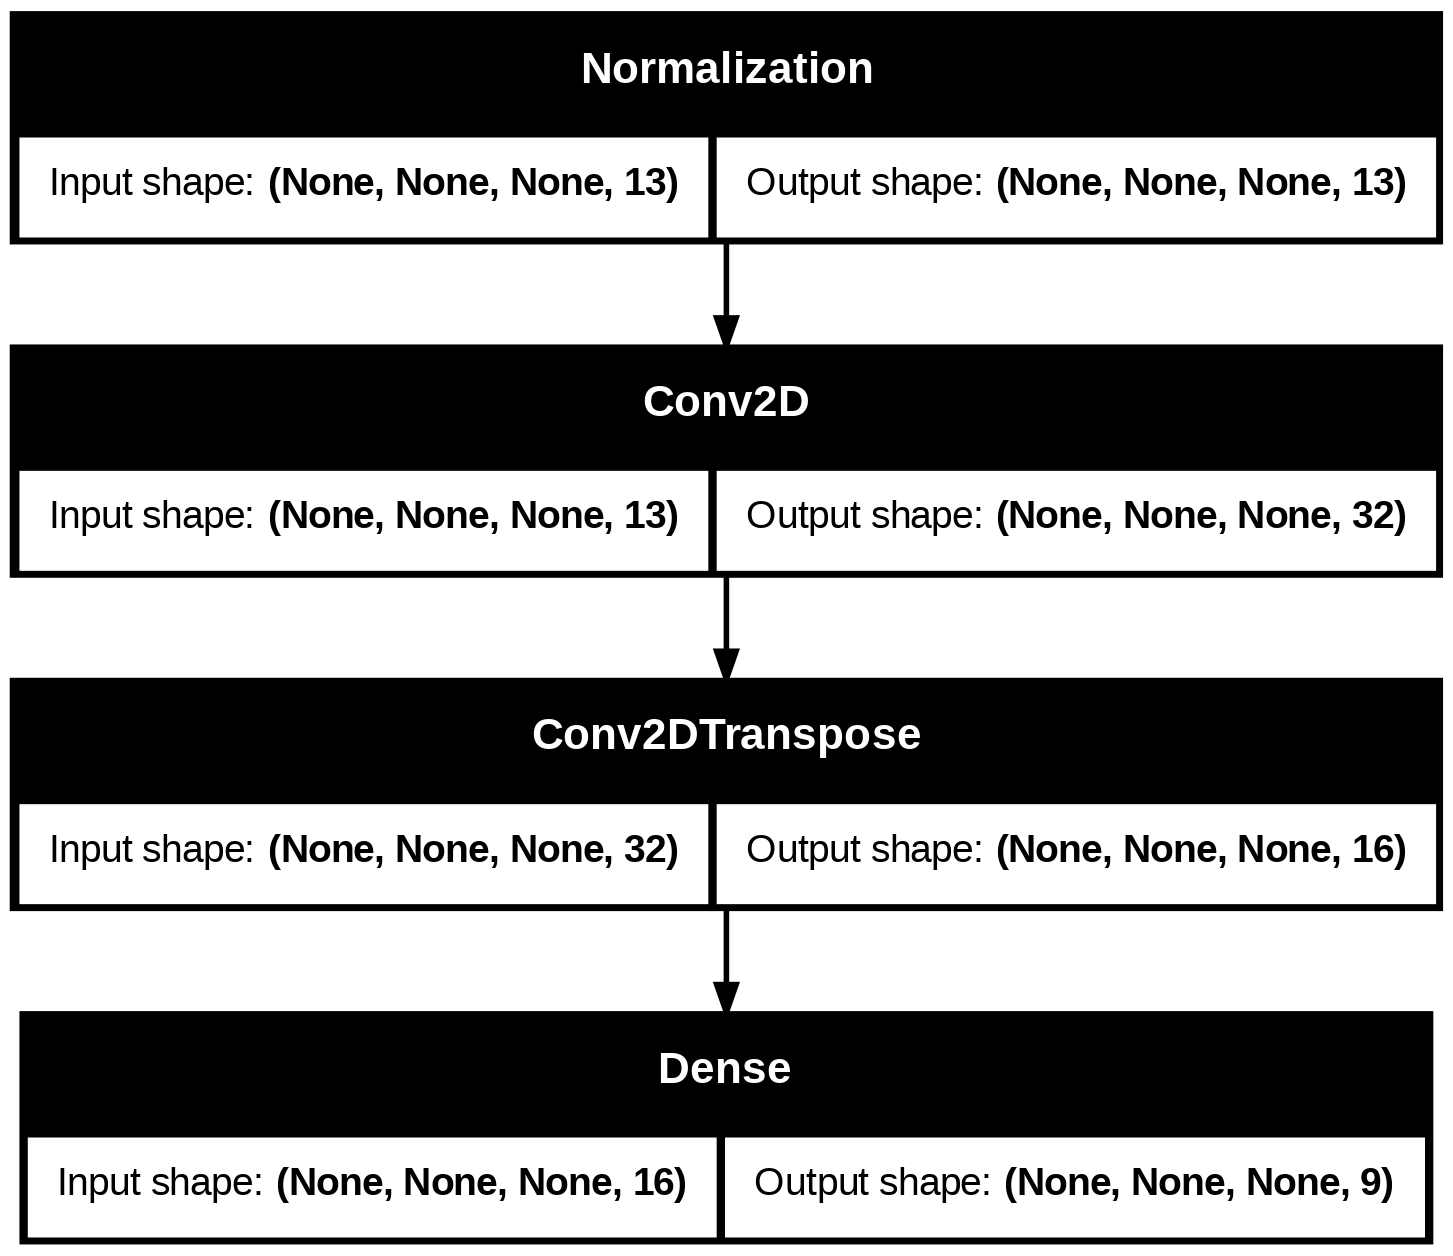

In [26]:
KERNEL_SIZE = 5

# Adapt the Normalization layer with the training dataset.
normalization = tf.keras.layers.Normalization(name="normalize")
normalization.adapt(train_dataset.map(lambda inputs, _: inputs))

# Define the Fully Convolutional Network.
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(None, None, NUM_INPUTS), name="inputs"),
        normalization,
        tf.keras.layers.Conv2D(32, KERNEL_SIZE, activation="relu", name="conv2D"),
        tf.keras.layers.Conv2DTranspose(
            16, KERNEL_SIZE, activation="relu", name="deconv2D"
        ),
        tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="landcover"), #the same Dense layer is applied to all pixels independently,
    ],
    name="FullyConvolutionalNetwork",
)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

Optimizers play an important role in how fast the model learns and how stable they are, so how do you know if you're using the right one?
Fortunately there's a simple rule of thumb.
Try the
[Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) first,
that should be good enough for most use cases.

> 💡 According to
> [Kingma et al., 2014](http://arxiv.org/abs/1412.6980), the method (Adam optimizer) is _"computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters"._ ([source](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam))

> 💡 For more information on the available optimizers, see the
> [`tf.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) module.

We can compile the model by letting it know which optimizer to use, which loss function to use for each output, and optionally the metrics we want to track.

In [46]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[
        tf.keras.metrics.OneHotIoU(
            num_classes=NUM_CLASSES,
            target_class_ids=list(range(NUM_CLASSES)),
        )
    ],
)

> 💡 We are using
[`OneHotIoU` (Intersection-Over-Union)](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/OneHotIoU)
as a metric, which is a common evaluation metric for semantic image segmentation.

Finally, we can train the model.
To train the model, we use the
[`tf.keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method.

We need to at least point it to the training and validation datasets.
We _shuffle_ the training dataset to keep each epoch a little more randomized.

By default, it trains the model on a single epoch, but it's a good idea to train on more epochs to get better results.

In [47]:
# Train the model.
model.fit(train_dataset, validation_data=test_dataset, epochs=10)

# Save it as files.
model.export("model")

Epoch 1/10
     11/Unknown 4s 92ms/step - loss: 1.2951 - one_hot_io_u_1: 0.3405

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 376ms/step - loss: 1.3007 - one_hot_io_u_1: 0.3381 - val_loss: 3.3712 - val_one_hot_io_u_1: 0.0105
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 1.0968 - one_hot_io_u_1: 0.3977 - val_loss: 3.4506 - val_one_hot_io_u_1: 0.0092
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 1.0386 - one_hot_io_u_1: 0.4140 - val_loss: 4.3898 - val_one_hot_io_u_1: 0.0105
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.9954 - one_hot_io_u_1: 0.4336 - val_loss: 4.0150 - val_one_hot_io_u_1: 0.0126
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.8528 - one_hot_io_u_1: 0.4614 - val_loss: 3.5221 - val_one_hot_io_u_1: 0.0104
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.7949 - one_hot_io_u_1: 0.4839 - val_loss: 3.3056 - val_one_hot_io_u_1: 0.0109
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.8644 - one_hot_io_u_1: 0.4903 - val_loss: 2.2528 - val_one_hot_io_u_1: 0.1031
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=model/.

In [56]:
from keras.layers import TFSMLayer

# Load the SavedModel using TFSMLayer
model = TFSMLayer("model", call_endpoint="serving_default")

In [53]:
!ls -lh model/

total 80K
drwxr-xr-x 2 root root 4.0K Jan 11 16:11 assets
-rw-r--r-- 1 root root   57 Jan 11 16:11 fingerprint.pb
-rw-r--r-- 1 root root  65K Jan 11 16:11 saved_model.pb
drwxr-xr-x 2 root root 4.0K Jan 11 16:11 variables


You can later load your model with [`tf.keras.models.load_model`](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model) to make predictions. ''It is old and not working anymore with recent versn of keras''  

**NOTE: ** If you want to load this way, you have to save your model with and extentions ".keras"

In [ ]:
#model = tf.keras.models.load_model("model")

In [58]:
# Use this instead

from keras.layers import TFSMLayer

# Load the SavedModel using TFSMLayer
model = TFSMLayer("model", call_endpoint="serving_default")

# 🔮 Model predictions

We trained on a very small dataset for a very short amount of time, but we can still get an idea of what the model learned.

The model behaves like a _function_.
It takes some inputs, in this case a map of the Sentinel-2 bands as a dense multidimensional array.
And it returns us some outputs, in this case as a map of probability distributions of the land cover classifications.

To test out the model, we trained a model on several GB of data for several hours, and you can find it on the [`pretrained-model`](pretrained-model) directory.
Feel free to use your locally trained model as well to see the differences.

In [60]:
# Optionally, load the pretrained model
# model = tf.keras.models.load_model("pretrained-model")

from keras.layers import TFSMLayer

# Load the SavedModel using TFSMLayer
model = TFSMLayer("pretrained-model", call_endpoint="serving_default")

It's important that we give the model data as close as possible to what it used to train.
For this example, we used the **median of 2020** to train our model, so we give our model the median  of the Sentinel-2 data of a given year.

Let's get some data, and making sure we grab it with our [`serving`](serving) module.
This makes sure we use _exactly_ the same data we used for training.

In [61]:
from visualize import show_inputs

inputs = get_input_patch(2018, (-121.526, 39.781), patch_size=512)
show_inputs(inputs)

Our inputs have shape `(width, height, bands)`, but must give the model batched inputs with the shape `(batch, width, height, bands)`.
Since we only have a single input, we can use `np.stack` to create a batch with a single element.
But we still need the _batch dimension_.

In [66]:
import numpy as np
probabilities = model(np.stack([inputs]))

In [74]:
import numpy as np

# We had a single input, so grab the first element from the predictions.
print(f"inputs : {inputs.dtype.name} {inputs.shape}")
#probabilities = model.predict(np.stack([inputs]))[0]  # not working for and old version of keras model.
# Since we load the old model with TFSMLayer, we have to use the below code for prediction
probabilities = np.array(model(np.stack([inputs]))['dense'][0])


print(f"probabilities : {probabilities.dtype} {probabilities.shape}")

inputs : float32 (512, 512, 13)
probabilities : float32 (512, 512, 9)


We got 9 outputs, one for every classification.
It represents the _probability_ for each classification for every pixel, also called a _probability distribution_.

Having the probabilities for every classification can be very useful, but for a quick visualization we're interested in having a discrete classification for every pixel.

We use the
[`np.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html)
function to get the index of the largest number, which corresponds to the classification with the highest probability.
Since we only have 9 classifications, it all fits into a `np.uint8`, which can represent up to 256 (2^8) different classifications.

In [75]:
predictions = probabilities.argmax(axis=-1).astype(np.uint8)
print(f"predictions : {predictions.dtype} {predictions.shape}")

predictions : uint8 (512, 512)


Here's how it all looks as a function to predict a single patch.

In [77]:
from visualize import show_outputs

# Our `show_outputs` function expects a shape of (width, height, 1)
# so we add an extra dimension at the end.
show_outputs(predictions[:, :, None])

# ⛵️ What's next?

Check out the following resources with more in-depth code and best practices.

* [![Open in Colab](https://github.com/googlecolab/open_in_colab/raw/main/images/icon16.png) 🌍 Land cover with TensorFlow](https://colab.research.google.com/github/GoogleCloudPlatform/python-docs-samples/blob/main/people-and-planet-ai/land-cover-classification/cloud-tensorflow.ipynb):
  Create a dataset, train a TensorFlow model, and get predictions at scale with Google Cloud.
* [![Open in Colab](https://github.com/googlecolab/open_in_colab/raw/main/images/icon16.png) 🗺 Land cover change](https://colab.research.google.com/github/GoogleCloudPlatform/python-docs-samples/blob/main/people-and-planet-ai/land-cover-classification/land-cover-change.ipynb):
  Explore different locations and see how the land cover has changed through time.